# Extreme Value Analysis 1 (Solution)


## Sampling extremes

### Objective

Apply sampling techniques to identify extremes within an historical database.

### Introduction

The first step to model the extreme observations of our loading variable is to extract those from our database. In this notebook, we will use the wave height dataset seen in the videos to put sampling techniques into practise. We will follow the next steps:

0. Load libraries and data
1. Sampling extremes with Block Maxima
2. Sampling extremes with Peak Over Threshold
3. Let's talk about threshold and declustering time selection

### 0. Load libraries and data

Install dependences if needed

In [ ]:
!pip install pandas numpy scipy statsmodels matplotlib datetime wget

Import necessary libraries (include more if needed).

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
from scipy.signal import find_peaks
import os
import matplotlib.pyplot as plt
import matplotlib
import datetime
import wget

Load the database obtained from a buoy from surfdrive.

In [2]:
data_name = wget.download('https://surfdrive.surf.nl/files/index.php/s/2Z1OHYg5Gv9PIAK/download')
data = pd.read_csv(data_name, sep = ';')
data.head()


  0% [                                                      ]       0 / 2462003
  0% [                                                      ]    8192 / 2462003
  0% [                                                      ]   16384 / 2462003
  0% [                                                      ]   24576 / 2462003
  1% [                                                      ]   32768 / 2462003
  1% [                                                      ]   40960 / 2462003
  1% [.                                                     ]   49152 / 2462003
  2% [.                                                     ]   57344 / 2462003
  2% [.                                                     ]   65536 / 2462003
  2% [.                                                     ]   73728 / 2462003
  3% [.                                                     ]   81920 / 2462003
  3% [.                                                     ]   90112 / 2462003
  3% [..                               


 70% [.....................................                 ] 1728512 / 2462003
 70% [......................................                ] 1736704 / 2462003
 70% [......................................                ] 1744896 / 2462003
 71% [......................................                ] 1753088 / 2462003
 71% [......................................                ] 1761280 / 2462003
 71% [......................................                ] 1769472 / 2462003
 72% [......................................                ] 1777664 / 2462003
 72% [.......................................               ] 1785856 / 2462003
 72% [.......................................               ] 1794048 / 2462003
 73% [.......................................               ] 1802240 / 2462003
 73% [.......................................               ] 1810432 / 2462003
 73% [.......................................               ] 1818624 / 2462003
 74% [.................................

,Date (GMT),Hs(m)
0,1985 09 24 21,0.22
1,1985 09 25 21,0.46
2,1985 09 26 00,0.73
3,1985 09 26 03,0.72
4,1985 09 26 06,0.75


The first column of the database corresponds to the date and time of each measurement, so we are going to give it the right format. The second column corresponds to the hourly measured significant wave height ($H_s$).

In [3]:
data['Date (GMT)'] = pd.to_datetime(data['Date (GMT)'])
data.head()

,Date (GMT),Hs(m)
0,1985-09-24 21:00:00,0.22
1,1985-09-25 21:00:00,0.46
2,1985-09-26 00:00:00,0.73
3,1985-09-26 03:00:00,0.72
4,1985-09-26 06:00:00,0.75


We can start the analysis of the data by plotting the time series.

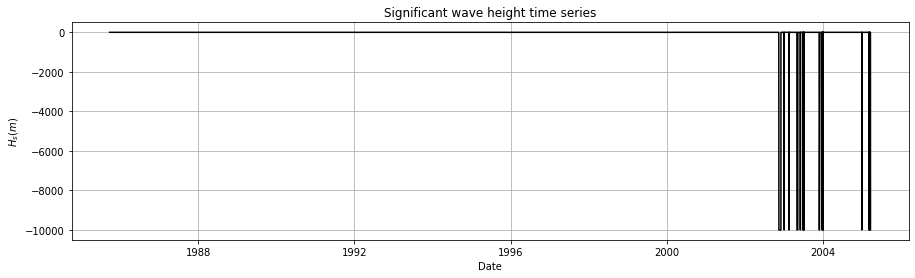

In [4]:
fig, axs = plt.subplots(1, 1)
axs.plot(data['Date (GMT)'], data['Hs(m)'], 'k', label='${H_s(m)}$')
axs.set_title('Significant wave height time series')
axs.set_xlabel('Date')
axs.set_ylabel('${H_s (m)}$')
fig.set_size_inches(15, 4)
axs.grid()
plt.show()

In the figure, you can see some outliers. When the buoy is not able to measure, it records -9,999. Before going ahead with the analysis, we need to remove these values. Afterwards, we can plot the data again.

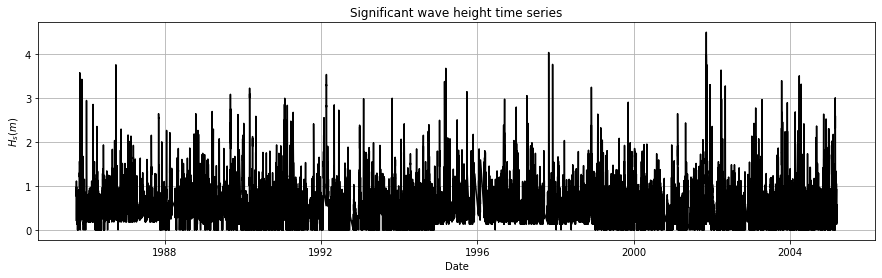

In [5]:
data = data[data['Hs(m)'] >= 0]
data.set_axis([np.linspace(0, len(data)-1, len(data), dtype = int)], axis = 'index', inplace = True)
fig, axs = plt.subplots(1, 1)
axs.plot(data['Date (GMT)'], data['Hs(m)'], 'k', label = '${H_s(m)}$')
axs.set_title('Significant wave height time series')
axs.set_xlabel('Date')
axs.set_ylabel('${H_s (m)}$')
fig.set_size_inches(15, 4)
axs.grid()

Now we have a clean database to work! As you can see, the buoy has been measuring from 1985 until 2005, so we have almost 20 years of measurements. However, these data are not enough to totally represent the right tail of the distribution (high return periods), so we need to model it.

### 1. Sampling extremes with Block Maxima

This first sampling technique consists of defining a time block and selecting the maximum observation within that time block.

**Task #1: identify extreme events using Block Maxima**. Define a function which implements Block Maxima with a time block equal to a year. The function must take as input the buoy data. The output of the function must be a dataframe with the two columns of the original data.

*Hint: using pd.DatetimeIndex(data['Date (GMT)']).year, you can extract the year of each observation*

In [ ]:
def yearly_maxima(data):
    min_year = min(pd.DatetimeIndex(data['Date (GMT)']).year)
    max_year = max(pd.DatetimeIndex(data['Date (GMT)']).year)
    max_list = pd.DataFrame(columns = data.columns)
    for i in range(min_year, max_year+1):
        block = data.loc[pd.DatetimeIndex(data['Date (GMT)']).year == i]
        idx_max = block['Hs(m)'].idxmax(axis = 0)
        max_list = pd.concat([max_list, block.loc[[idx_max]]])
    return max_list

In [6]:
def yearly_maxima(data):
    idx_max = data.groupby(pd.DatetimeIndex(data['Date (GMT)']).year)['Hs(m)'].idxmax()
    max_list = data.loc[idx_max]
    return max_list

Let's apply your function to our data!

In [7]:
yearly_maxima_list = yearly_maxima(data)
yearly_maxima_list

,Date (GMT),Hs(m)
230,1985-10-28 02:00:00,3.57
2481,1986-09-30 18:00:00,3.75
4724,1987-11-03 21:00:00,2.64
6168,1988-10-16 19:00:00,2.64
7957,1989-09-05 17:00:00,3.08
10237,1990-03-03 22:00:00,3.22
16649,1991-01-26 14:00:00,2.99
22659,1992-02-20 02:00:00,3.53
35113,1993-10-27 04:00:00,2.99
37723,1994-02-16 19:00:00,2.41


We have obtained one maximum value per year, so 21 extreme values. We can also plot it on our timeseries to see how it looks!

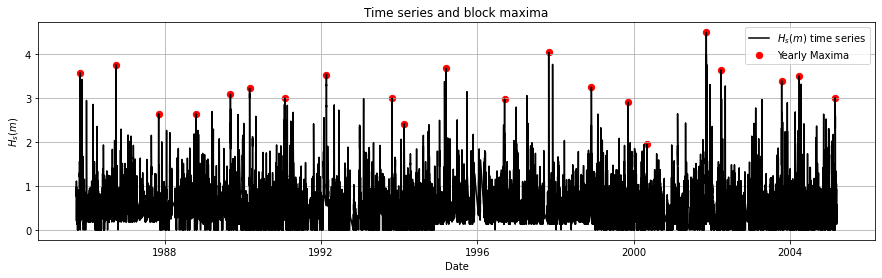

In [8]:
fig, axs = plt.subplots(1, 1)
axs.plot(data['Date (GMT)'], data['Hs(m)'], 'k', label='${H_s(m)}$ time series')
axs.scatter(yearly_maxima_list['Date (GMT)'], yearly_maxima_list['Hs(m)'], 40, 'r', label = 'Yearly Maxima')
axs.set_title('Time series and block maxima')
axs.set_xlabel('Date')
axs.set_ylabel('${H_s (m)}$')
fig.set_size_inches(15, 4)
axs.grid()
axs.legend()

### 2. Sampling extremes with Peak Over Threshold

Let's go with the second technique: Peak Over Threshold (POT). This sampling technique involves defining two parameters:
- A threshold: value above which an observation is considered extreme.
- Declustering time: minimum time distance between two extreme observations.

Based on these parameters, we can select those observations which are above the threshold and present a minimum distance equal to the declustering time between events.

**Task #2: identify extreme events using the POT method**. Define a function which implements the POT method. The function must take as input (1) the buoy data, (2) the threshold, and (3) the declustering time. The output of the function must be a dataframe with the same columns as the data.

*Hint: You can use the function find_peaks from SciPy library.*

In [9]:
def pot_method(data, threshold, dtime):
    idx_pot, _ = find_peaks(data['Hs(m)'], height = threshold, distance = dtime)
    pot_list = data.loc[idx_pot]
    return pot_list

Let's apply your function to your data! Do it with a threshold=2.5m and declustering time=48h.

In [10]:
pot_maxima = pot_method(data, threshold = 2.5, dtime = 48)
pot_maxima

,Date (GMT),Hs(m)
230,1985-10-28 02:00:00,3.57
320,1985-11-16 16:00:00,3.42
593,1985-12-30 00:00:00,2.94
992,1986-03-01 03:00:00,2.85
2481,1986-09-30 18:00:00,3.75
4724,1987-11-03 21:00:00,2.64
6168,1988-10-16 19:00:00,2.64
7140,1989-03-18 17:00:00,2.69
7957,1989-09-05 17:00:00,3.08
8005,1989-09-07 21:00:00,2.53


Let's see how much extreme values we got.

In [11]:
len(pot_maxima)

54

That is much more than the 21 extreme observations we got with Yearly Maxima, right?

Let's compare both methods visually!

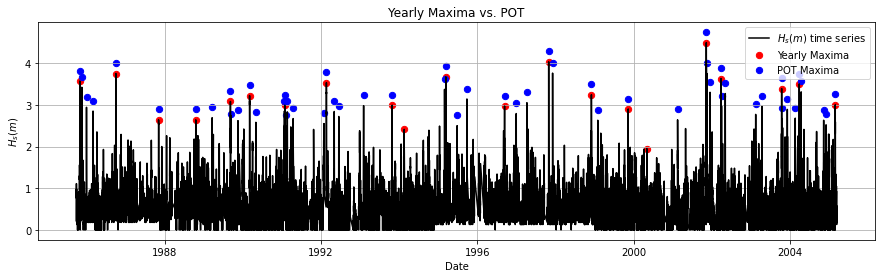

In [12]:
fig, axs = plt.subplots(1, 1)
axs.plot(data['Date (GMT)'], data['Hs(m)'], 'k', label = '${H_s(m)}$ time series')
axs.scatter(yearly_maxima_list['Date (GMT)'], yearly_maxima_list['Hs(m)'], 40, 'r', label = 'Yearly Maxima')
axs.scatter(pot_maxima['Date (GMT)'], pot_maxima['Hs(m)']+0.25, 40, 'b', label = 'POT Maxima')
axs.set_title('Yearly Maxima vs. POT')
axs.set_xlabel('Date')
axs.set_ylabel('${H_s (m)}$')
fig.set_size_inches(15, 4)
axs.grid()
axs.legend()

Note that for the following phases of Extreme Value Analysis, you need the excesses over the threshold when applying POT method, not the value of the peak itself. This is, if I have identified an extreme observation of 3.5m with a threshold of 2m, I will model an excess of 3.5-2=1.5m.

### 3. Let's talk about threshold and declustering time selection

Now, we are going to discuss about the appropriate selection of the parameters of the POT sampling technique.

Let's sample again our time series using POT but with different parameters. Let's use now threshold=1.5 and declustering time=12h.

In [13]:
pot_maxima_2 = pot_method(data, threshold = 1.5, dtime = 12)
len(pot_maxima_2)

465

Now, we have obtained much more extreme values. That's better for our analysis. Let's compare the selected extremes in a plot.

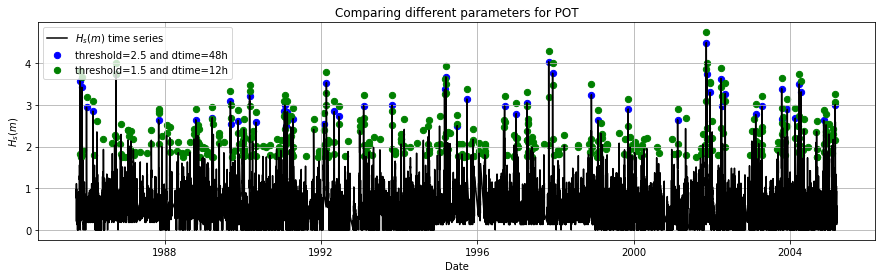

In [14]:
fig, axs = plt.subplots(1, 1)
axs.plot(data['Date (GMT)'], data['Hs(m)'], 'k', label = '${H_s(m)}$ time series')
axs.scatter(pot_maxima['Date (GMT)'], pot_maxima['Hs(m)'], 40, 'b', label = 'threshold=2.5 and dtime=48h')
axs.scatter(pot_maxima_2['Date (GMT)'], pot_maxima_2['Hs(m)']+0.25, 40, 'g', label = 'threshold=1.5 and dtime=12h')
axs.set_title('Comparing different parameters for POT')
axs.set_xlabel('Date')
axs.set_ylabel('${H_s (m)}$')
fig.set_size_inches(15, 4)
axs.grid()
axs.legend()

Let's zoom in and analyze one wave storm.

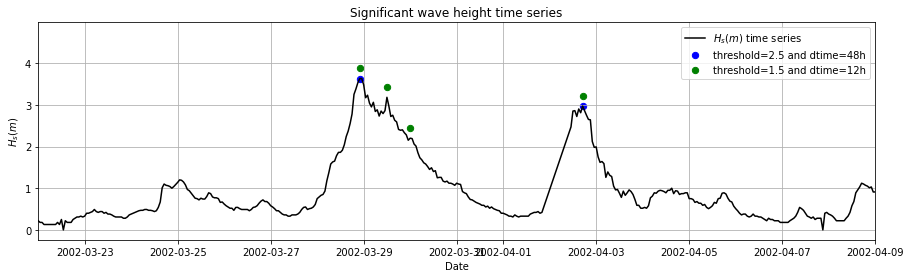

In [15]:
fig, axs = plt.subplots(1, 1)
axs.plot(data['Date (GMT)'], data['Hs(m)'], 'k', label='${H_s(m)}$ time series')
axs.scatter(pot_maxima['Date (GMT)'], pot_maxima['Hs(m)'], 40, 'b', label = 'threshold=2.5 and dtime=48h')
axs.scatter(pot_maxima_2['Date (GMT)'], pot_maxima_2['Hs(m)']+0.25, 40, 'g', label = 'threshold=1.5 and dtime=12h')
axs.set_title('Significant wave height time series')
axs.set_xlabel('Date')
axs.set_ylabel('${H_s (m)}$')
fig.set_size_inches(15, 4)
axs.grid()
axs.set_xlim(datetime.datetime(2002, 3, 22, 0, 0), datetime.datetime(2002, 4, 9, 0, 0))
axs.legend()

In the previous plot we can see that there was a time storm between the 28th March 2002 and 1st April 2022. Using threshold=2.5 and declustering time=48h, one extreme value is sampled from the wave storm. Using threshold=1.5 and declustering time=12h, three values are selected. 

**Task #3. What do you think is best? Explain your answer.**


As explained in the theory, Extreme Value Analysis is based on the hypothesis that  extremes are independent and identically distributed (iid conditions). Thus, the threshold and the declustering time need to be selected so this hypothesis is fulfilled. In this example, it means that only one value, the most extreme, per storm event should be selected. If more than one value per storm event is selected, such values will not be independent. 

But what is independence?

Two events, namely A and B, are independent if P(A AND B)=P(A)xP(B).

You will go back to this formal definition later in the MUDE. Here, we are going to address it in a qualitative manner, so you gain some intuition into it.

As you can see in the previous plot, there is a series of large observations between 28th March 2002 and 1st April 2002. Thus, it is reasonable to assume that all of it is one wave storm. During a wave storm, if I observe an extreme value, it is more likely that I observe another one afterwards. Also, these extreme values are caused by the same drivers. Therefore, the observations within a wave storm are related to each other and we cannot assume that they are independent anymore. We will be interested in sampling the largest observation within each wave storm, so we will fulfill the independence hypothesis.

